In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Harris-Stephens Corner Detection

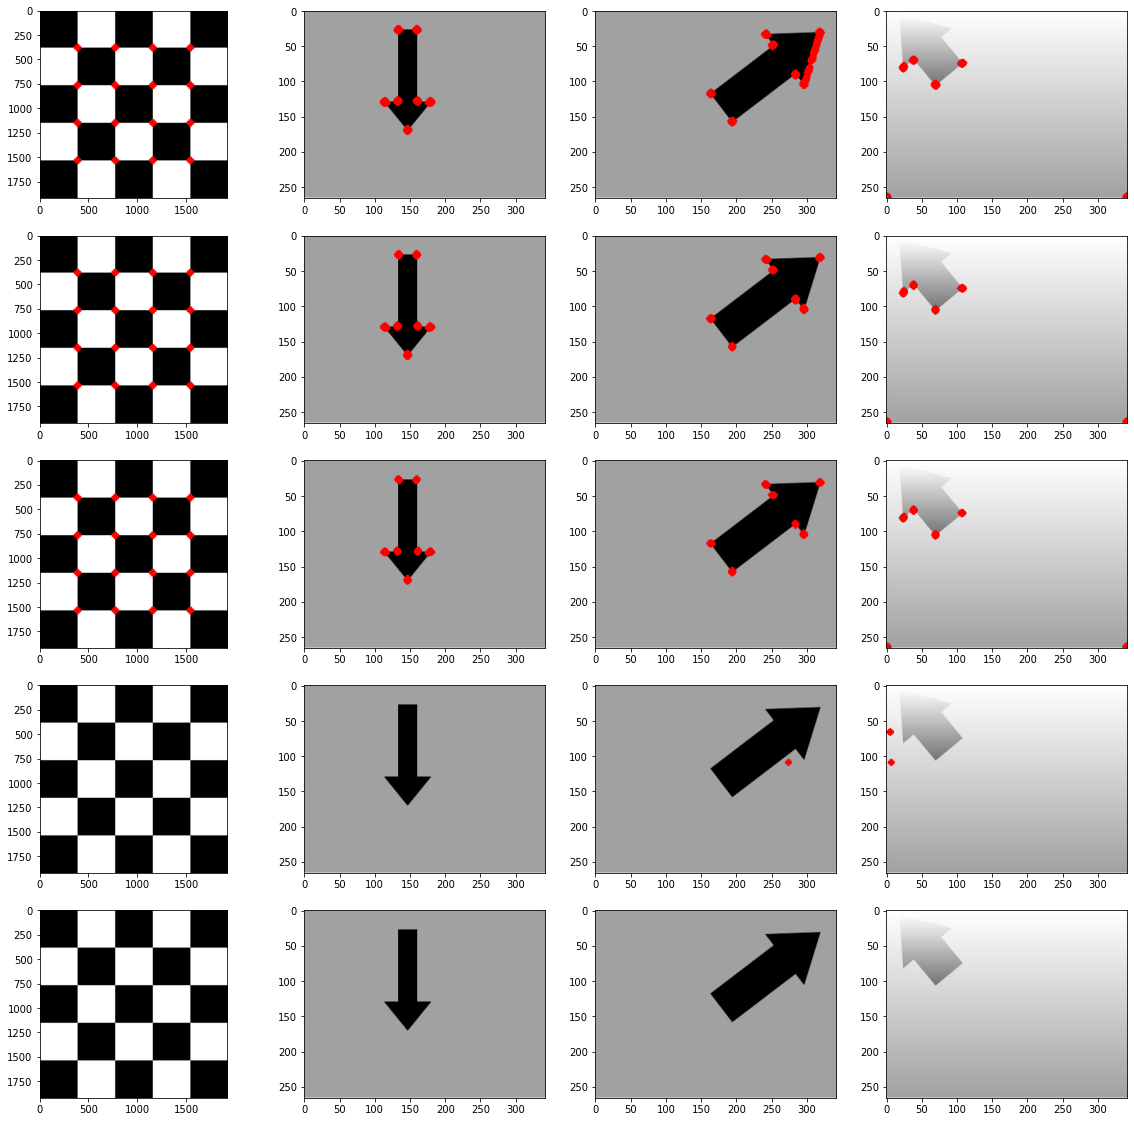

In [2]:
def draw_corners(img_path, k):
    Im = cv2.imread(f'./images/{img_path}', cv2.IMREAD_GRAYSCALE)
    corners = cv2.cornerHarris(Im, blockSize=3, ksize=3, k=k)
    marked = cv2.cvtColor(Im, cv2.COLOR_GRAY2RGB)
    max_val = 0.01*corners.max()
    scaled_size = Im.shape[0]//50

    for i, y in enumerate(corners):
        for j, x in enumerate(y):
            if x > max_val:
                marked = cv2.drawMarker(marked, (j, i), color=(255,0,0), markerType=cv2.MARKER_CROSS, markerSize=scaled_size, thickness=scaled_size)
                
    plt.imshow(marked)

paths = ['chessboard.png', 'arrow_1.jpg', 'arrow_2.jpg', 'arrow_3.jpg']
k_vals = [0.001, 0.04, 0.1, 0.25, 0.3]

plt.figure(figsize=(20,20))

for i, path in enumerate(paths):
    for j, k in enumerate(k_vals):
        plt.subplot(5, 4, (j*4)+i+1)
        draw_corners(path, k)

plt.show()

# SIFT Feature Detection

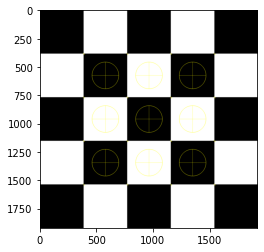

In [2]:
img = cv2.imread('images/chessboard.png', cv2.IMREAD_GRAYSCALE)

sift = cv2.xfeatures2d.SIFT_create()

kp = sift.detect(img, None)

out_img = cv2.drawKeypoints(img, kp, None, (255, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(out_img)

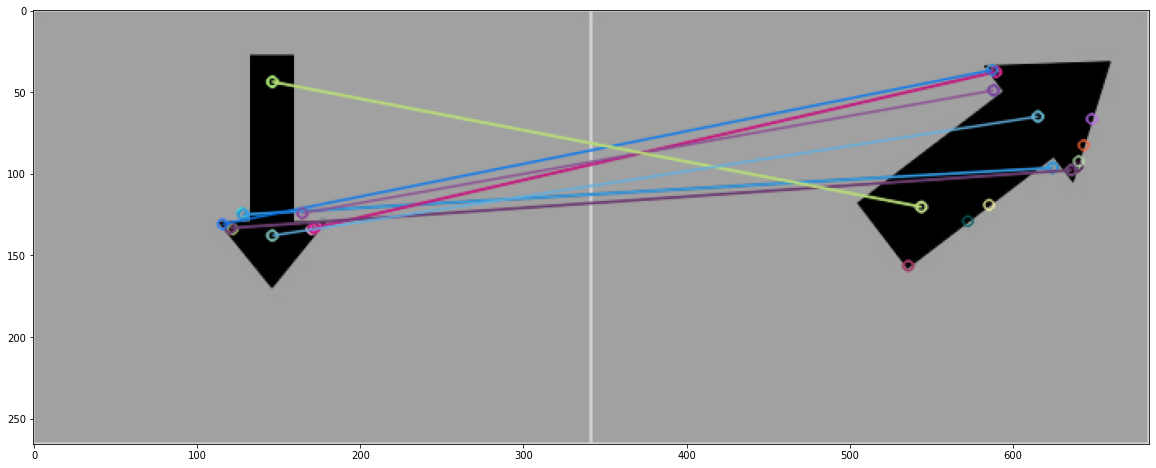

In [3]:
arrow1 = cv2.imread('images/arrow_1.jpg', cv2.IMREAD_GRAYSCALE)
arrow2 = cv2.imread('images/arrow_2.jpg', cv2.IMREAD_GRAYSCALE)

sift = cv2.xfeatures2d.SIFT_create()

kp1, des1 = sift.detectAndCompute(arrow1, None)
kp2, des2 = sift.detectAndCompute(arrow2, None)

# initialize Brute force matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(des1,des2)

#sort the matches 
matches = sorted(matches, key= lambda match : match.distance)

matched_img = cv2.drawMatches(arrow1, kp1, arrow2, kp2, matches[:30], None) 

plt.figure(figsize=(20,20))
plt.imshow(matched_img)

In [4]:
# Use sift to find features in video by tracking frames
cap = cv2.VideoCapture('images/finger_track.mp4')

out = cv2.VideoWriter('project.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, (20,20))

# video stabilization algorithm based on the extraction and tracking of scale invariant feature transform features through video frames
stabilizer = cv2.stabilizer.Stabilizer(cv2.stabilizer.MotionModel(), cv2.stabilizer.StabilizationFlag_Default)

ret, frame = cap.read()

while ret:
    # extract features from frame
    kp, des = sift.detectAndCompute(frame, None)

    # get translation matrix
    translation_matrix, status = stabilizer.estimate(frame)

    # get stabilized frame
    stabilized = stabilizer.stabilize(frame)

    # get keypoints from stabilized frame
    kp_stabilized, des_stabilized = sift.detectAndCompute(frame, None)

    # find matches between keypoints
    matches = bf.match(des, des_stabilized)

    # sort the matches 
    matches = sorted(matches, key= lambda match : match.distance)

    # get matched keypoints
    matched_kp = [kp[i.queryIdx] for i in matches[:30]]

    # get matched keypoints from stabilized frame
    matched_kp_stabilized = [kp_stabilized[i.trainIdx] for i in matches[:30]]

    # draw matched keypoints
    matched_img = cv2.drawMatches(frame, matched_kp, frame, matched_kp_stabilized, matches[:30], None)

    # out.write(cv2.imread(matched_img))

    ret, frame = cap.read()


AttributeError: module 'cv2' has no attribute 'stabilizer'

In [5]:
def sift_detector(new_image, image_template):
    # Function that compares input image to template
    # It then returns the number of SIFT matches between them
    image1 = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
    image2 = image_template

    # Create SIFT detector object
    sift = cv2.xfeatures2d.SIFT_create()
    # Obtain the keypoints and descriptors using SIFT
    _, descriptors_1 = sift.detectAndCompute(image1, None)
    _, descriptors_2 = sift.detectAndCompute(image2, None)

    # Define parameters for our Flann Matcher
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 3)
    search_params = dict(checks = 100)

    # Create the Flann Matcher object
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Obtain matches using K-Nearest Neighbor Method
    # the result 'matchs' is the number of similar matches found in both images
    matches = flann.knnMatch(descriptors_1, descriptors_2, k=2)

    # Store good matches using Lowe's ratio test
    good_matches = []
    for m,n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m) 
    return len(good_matches)

cap = cv2.VideoCapture(0)

# Load our image template, this is our reference image
image_template = cv2.imread('images/cup.jpg', 0) 

while True:
    # Get webcam images
    ret, frame = cap.read()

    # Get height and width of webcam frame
    height, width = frame.shape[:2]

    # Define ROI Box Dimensions
    top_left_x = int (width / 3)
    top_left_y = int ((height / 2) + (height / 4))
    bottom_right_x = int ((width / 3) * 2)
    bottom_right_y = int ((height / 2) - (height / 4))

    # Draw rectangular window for our region of interest   
    cv2.rectangle(frame, (top_left_x,top_left_y), (bottom_right_x,bottom_right_y), 255, 3)

    # Crop window of observation we defined above
    cropped = frame[bottom_right_y:top_left_y , top_left_x:bottom_right_x]

    # Flip frame orientation horizontally
    frame = cv2.flip(frame,1)

    # Get number of SIFT matches
    matches = sift_detector(cropped, image_template)

    # Display status string showing the current no. of matches 
    cv2.putText(frame,str(matches),(450,450), cv2.FONT_HERSHEY_COMPLEX, 2,(0,255,0),1)

    # Our threshold to indicate object deteciton
    # We use 10 since the SIFT detector returns little false positves
    threshold = 10

    # If matches exceed our threshold then object has been detected
    if matches > threshold:
        cv2.rectangle(frame, (top_left_x,top_left_y), (bottom_right_x,bottom_right_y), (0,255,0), 3)
        cv2.putText(frame,'Object Found',(50,50), cv2.FONT_HERSHEY_COMPLEX, 2 ,(0,255,0), 2)
    cv2.imshow('Object Detector using SIFT', frame)
    
    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break

cap.release()
cv2.destroyAllWindows()